<a href="https://colab.research.google.com/github/Rauulito/Tecnicas_OYC/blob/main/Introduccion.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

##La ecuacion de conveccion 1D


Vamos a ver nuestro primer ejemplo de ecuación diferencial: la ecuación de convección 1D.

$$
\phi_t + u \phi_x = 0
$$

En este caso, la variable conservativa es $\phi(x, t)$ y el flujo es $f(\phi(x,t)) = u \phi(x, t)$ donde $u$ es la velocidad, un valor escalar constante. Esta ecuación es muy útil por varios motivos. En primer lugar, considerando condiciones de contorno periódicas, tiene solución analítica

$$
\phi(x,t) = \phi_0(x - ut)
$$

donde $\phi_0$ es la condición inicial. A grandes rasgos, la condición inicial se propagará en $x$ a la velocidad $u$. Esto convierte a la ecuación de convección 1D como un perfecto benchmark para probar diferentes métodos numéricos.

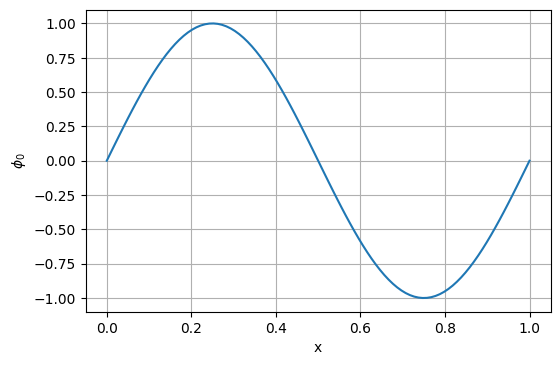

In [1]:

import numpy as np
import math
import matplotlib.pyplot as plt

x = np.linspace(0,1,100)
p = np.sin(2*math.pi*x)

plt.figure(dpi=100)
plt.plot(x, p)
plt.grid(True)
plt.xlabel('x')
plt.ylabel('$\phi_0$')
plt.show()

In [3]:
from matplotlib import animation, rc
rc('animation', html='html5')

def update(i):
    ax.clear()
    ax.plot(x, ps[i], "b")
    ax.set_xlabel('x')
    ax.set_ylabel('$\phi$')
    ax.set_title(f't = {ts[i]:.3f}')
    ax.grid(True)
    return ax

def compute_sol(x, u, t):
    return np.sin(2*math.pi*(x - u*t))

u = 1
ts = np.linspace(0,1,50)
ps = []
for t in ts:
    p = compute_sol(x, u, t)
    ps.append(p)

fig = plt.figure(dpi=100)
ax = plt.subplot(1,1,1)
anim = animation.FuncAnimation(fig, update, frames=len(ps), interval=200)
plt.close()

anim


###Resolucion de volumenes finitos



Lo primero que necesitamos para resolver la ecuación es discretizar nuestro dominio en un conjunto de celdas.

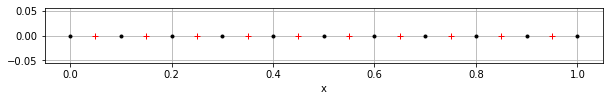

In [5]:
L, N, u = 1., 10, 1.
dx, dt = L / N, (L / N) / u

f = np.linspace(0,L,N+1) # caras
c = np.linspace(0.5*dx,L-0.5*dx,N) # celdas

plt.figure(figsize=(10,1))
plt.plot(f, np.zeros(N+1), '.k')
plt.plot(c, np.zeros(N), '+r')
plt.grid(True)
plt.xlabel('x')
plt.show()

Ahora, nuestra condición inicial estará definida en cada celda como el valor en su centroide.

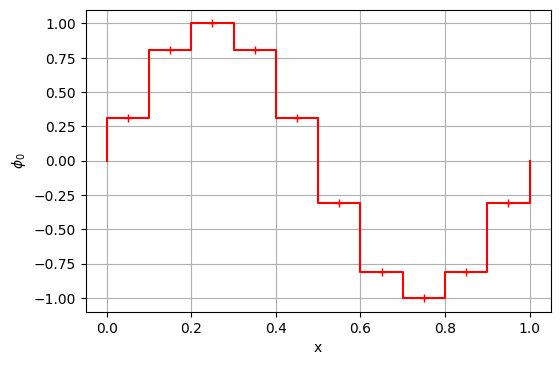

In [6]:
p0 = np.sin(2*math.pi*c)

plt.figure(dpi=100)
plt.plot(c, p0, '+r')
a, b = [0], [0]
for i in range(N):
    a += [c[i] - 0.5*dx, c[i], c[i] + 0.5*dx]
    b += [p0[i], p0[i], p0[i]]
a += [1]
b += [0]
plt.plot(a, b, '-r')
plt.grid(True)
plt.xlabel('x')
plt.ylabel('$\phi_0$')
plt.show()

Como hemos visto antes, para calcular la evolución temporal de la variable conservativa necesitamos calcular su flujo a través de sus caras. Un par de esquemas simples son los conocidos como *upwind* (UDS), que usa el valor aguas arriba, y *central* (CDS) que usa el valor medio entre los valores a cada lado de la cara.

In [7]:
import numpy as np

def compute_flux(p, u, scheme='uds'):
    N = len(p)
    f = np.ones(N+1)
    for i in range(N+1):
        l, r = i-1, i
        if i == 0:
            l = N - 1
        elif i == N:
            r = 0
        if scheme == 'uds':
            f[i] = p[l] if u > 0 else p[r]
        elif scheme == 'cds':
            f[i] = 0.5*(p[l] + p[r])
        else:
            raise 'invalid scheme'
    return f

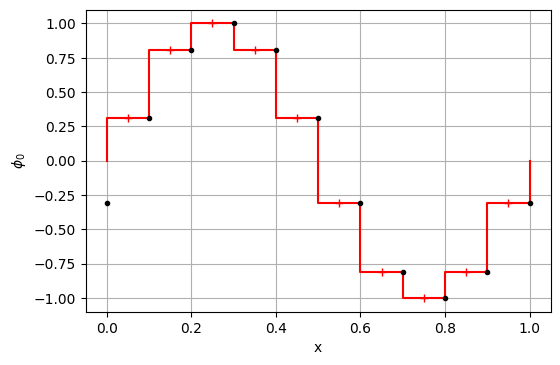

In [8]:
pf = compute_flux(p0, u, 'uds')

plt.figure(dpi=100)
plt.plot(c, p0, '+r')
plt.plot(a, b, '-r')
plt.plot(f, pf, '.k')
plt.grid(True)
plt.xlabel('x')
plt.ylabel('$\phi_0$')
plt.show()

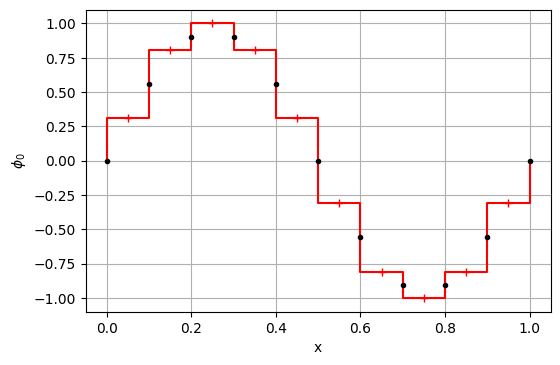

In [9]:
pf = compute_flux(p0, u, 'cds')

plt.figure(dpi=100)
plt.plot(c, p0, '+r')
plt.plot(a, b, '-r')
plt.plot(f, pf, '.k')
plt.grid(True)
plt.xlabel('x')
plt.ylabel('$\phi_0$')
plt.show()

Para cada celda, calcularemos la variación de la magnitud conservativa como la cantidad que sale por la cara de la derecha menos la que entra por la cara izquierda (teniendo en cuenta el signo).

In [13]:
def sum_fluxes(pf):
	N = len(pf) - 1
	r = np.zeros(N)
	for i in range(N):
		r[i] = pf[i] - pf[i+1]
	return r

Por último, podemos actualizar el resultado usando un esquema de integración temporal, en este caso aplicamos un esquema sencillo de primer orden.

$$
    \frac{\partial \phi}{\partial t} \approx \frac{\phi^{n+1} - \phi^n}{t^{n+1} - t^{n}}
$$

In [14]:
def update_p(p0, r, dt, dx):
	N = len(p0)
	p = np.zeros(N)
	for i in range(N):
		p[i] = p0[i] + (dt/dx)*r[i]
	return p

In [15]:
p0 = np.sin(2*math.pi*c)
pf = compute_flux(p0, u)
r = sum_fluxes(pf)
p = update_p(p0, r, dt, dx)

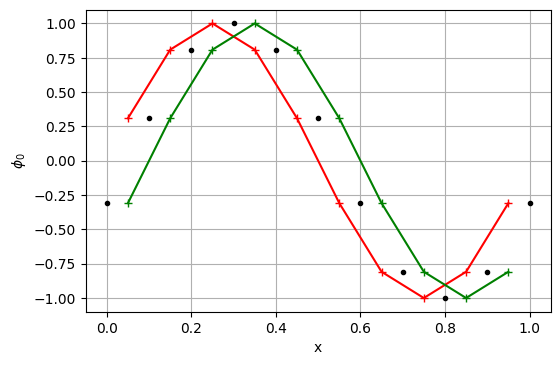

In [16]:
plt.figure(dpi=100)
plt.plot(c, p0, '+-r')
plt.plot(f, pf, '.k')
plt.plot(c, p, '+-g')
plt.grid(True)
plt.xlabel('x')
plt.ylabel('$\phi_0$')
plt.show()

In [17]:
pf = compute_flux(p, u)
r = sum_fluxes(pf)
p1 = update_p(p, r, dt, dx)

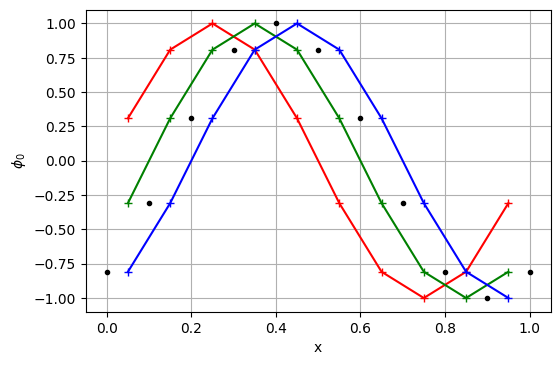

In [18]:
plt.figure(dpi=100)
plt.plot(c, p0, '+-r')
plt.plot(f, pf, '.k')
plt.plot(c, p, '+-g')
plt.plot(c, p1, '+-b')
plt.grid(True)
plt.xlabel('x')
plt.ylabel('$\phi_0$')
plt.show()

In [19]:
def run_sim(cfl = 1., scheme='uds'):
    p0 = np.sin(2*math.pi*c)
    ps = [p0]
    pa = [p0]
    ts = [0]
    t = 0
    dt = cfl * (L / N) / u
    while t + dt < 1.:
        t += dt
        pf = compute_flux(p0, u, scheme)
        r = sum_fluxes(pf)
        p = update_p(p0, r, dt, dx)
        ps.append(p)
        pa.append(compute_sol(c, u, t))
        ts.append(t)
        p0 = p.copy()
    return ps, pa, ts

In [20]:
def update(i):
    ax.clear()
    ax.plot(c, pa[i], "-b")
    ax.plot(c, ps[i], "+-r")
    ax.set_xlabel('x')
    ax.set_ylabel('$\phi$')
    ax.set_title(f't = {ts[i]:.3f}')
    ax.grid(True)
    ax.set_ylim(-1.1,1.1)
    return ax

In [21]:
ps, pa, ts = run_sim()

fig = plt.figure(dpi=100)
ax = plt.subplot(1,1,1)
anim = animation.FuncAnimation(fig, update, frames=len(ps), interval=200)
plt.close()

anim

En este caso particular, resolver la ecuación de convección con un esquema UDS en una malla regular con un incremento temporal $dt = \frac{dx}{u}$ y velocidad constante es equivalente a la solución analítica. Esto es debido a que, bajo estas condiciones especiales, el flujo calculado es exacto. Esto, sin embargo, nunca será el caso ya que trabajaremos con mallas irregulares, la velocidad del fluido será variables, etc. En estos casos, el uso de un esquema UDS resulta en una solución artificalmente viscosa.

In [22]:
ps, pa, ts = run_sim(cfl=0.5)

fig = plt.figure(dpi=100)
ax = plt.subplot(1,1,1)
anim = animation.FuncAnimation(fig, update, frames=len(ps), interval=200)
plt.close()

anim

El esquema CDS, por otro lado, acumulará errores debido a la aproximación que resultan en la divergencia de la simulación.

In [23]:
ps, pa, ts = run_sim(cfl=0.5, scheme="cds")

fig = plt.figure(dpi=100)
ax = plt.subplot(1,1,1)
anim = animation.FuncAnimation(fig, update, frames=len(ps), interval=200)
plt.close()

anim

Para aliviar estos problemas se suele recurrir a esquemas numéricos de alto nivel (como por ejemplo los esquemas Runge Kutta para la integración temporal), el uso de mallas muy densas y saltos temporales muy pequeños con el objetivo de reducir al mínimo los errores de aproximación. Este es el principal motivo por el que resolver ecuaciones diferenciales con métodos numéricos suele requerir de grandes requisitos computacionales. La pregunta ahora es: ¿podemos mejorar esto con redes neuronales? La respuesta es ¡SÍ! 